# Create ACS Index and Azure SQL Database for Avatar Demo
Use this notebook to create an Azure Cognitive Search Index and an Azure SQL Database and populate demo content for the Avatar outdoor shop application.  

Ensure that you have the the Microsoft ODBC driver for SQL Server installed. Here are the instructions for Linux based systems:  
https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/installing-the-microsoft-odbc-driver-for-sql-server?view=sql-server-ver16&tabs=ubuntu18-install%2Calpine17-install%2Cdebian8-install%2Credhat7-13-install%2Crhel7-offline#18


## Setup

In [1]:
# Install the required libraries
%pip install azure-search-documents==11.4.0b6 openai==0.28.1 tenacity pyodbc

# Install library for Azure Authentication
%pip install azure-identity azure-storage-blob

  Using cached openai-0.28.1-py3-none-any.whl.metadata (11 kB)
Using cached openai-0.28.1-py3-none-any.whl (76 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.58.1
    Uninstalling openai-1.58.1:
      Successfully uninstalled openai-1.58.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
promptflow-tools 1.4.0 requires openai>=1.0.0, but you have openai 0.28.1 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


In [71]:
import os
import json  
import pandas as pd

import pyodbc
import requests
import inspect

import openai  
from tenacity import retry, wait_random_exponential, stop_after_attempt  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SearchField,  
    SemanticSettings,  
    VectorSearch,  
    VectorSearchAlgorithmConfiguration,  
)  

You need to have the following settings for your Azure resources defined in the `local.settings.json` file in the __api__ subfolder to populate the demo content for the outdoor app:

In [72]:
#%pwd
#!cd c:/users/chihengchou/downloads/work/work/gen-cv-forked/gen-cv/avatar/interactive
%cd c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - aitour\\gen-cv\\avatar\\interactive
%pwd

c:\Users\chihengchou\Downloads\work\work\gen-cv-forked - aitour\gen-cv\avatar\interactive


'c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - aitour\\gen-cv\\avatar\\interactive'

In [73]:
# Load JSON file
with open('./api/local.settings.json', 'r') as file:
    data = json.load(file)

# Azure Cognitive Search
service_endpoint = data["Values"]["AZURE_SEARCH_ENDPOINT"]
key = data["Values"]["AZURE_SEARCH_API_KEY"]
index_name = data["Values"]["AZURE_SEARCH_INDEX"]

# Azure OpenAI
openai.api_type = "azure"
openai.api_key = data["Values"]["AZURE_OPENAI_API_KEY"]
openai.api_base = data["Values"]["AZURE_OPENAI_ENDPOINT"]
openai.api_version = data["Values"]["AZURE_OPENAI_API_VERSION"]
AOAI_embeddings_deployment = data["Values"]["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"]


## Create Cognitive Search Index
First, we create a new Index with demo data to the Cognitive Search service that you have deployed manually.

In [75]:
credential = AzureKeyCredential(key)

# csv原始資料需要去掉/n
df = pd.read_csv('data/products_cs_index.csv', dtype={'id': str})

# display(df.head())
display(df.tail())
input_data = df.to_dict(orient='records')

,id,content,product_image_file
1,6,'精彩演講:以下是活動中的一些重點演講：- AI Transformation：Trans...,6.png
2,7,'本次 Microsoft AI Tour Taipei 活動將於台北國際會議中心舉辦',7.png
3,8,'停車空間 - 國際會議中心: 50元／時，遇特定展覽調整為60元／時，費率如遇調整，以現...,8.png
4,9,'Copilot 相關議程:1. AI Transformation：Transform ...,9.png
5,10,'展場的合作夥伴1. 中華電信 提供電信網路、雲端服務、資安管理等解決方案。2. 宏...,10.png


In [76]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def generate_embeddings(text):
    response = openai.Embedding.create(
        input=text, engine=AOAI_embeddings_deployment)
    embeddings = response['data'][0]['embedding']
    return embeddings

In [77]:
# Generate embeddings for title and content fields
for item in input_data:
    content = item['content']
    content_embeddings = generate_embeddings(content)
    item['content_vector'] = content_embeddings

In [78]:
# Output embeddings to docVectors.json file
with open("./data/product-catalog-vectors.json", "w") as f:
    json.dump(input_data, f)

In [79]:
# Delete ACS index if it exists
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

try:
    if index_client.get_index(index_name):
        print('Deleting existing index...')
        index_client.delete_index(index_name)

except:
    print('Index does not exist. No need to delete it.')

Deleting existing index...


In [80]:
# Create a search index
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="content", type=SearchFieldDataType.String),
    SearchField(name="content_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                 searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SimpleField(name="product_image_file", type=SearchFieldDataType.String),
]

vector_search = VectorSearch(
    algorithm_configurations=[
        VectorSearchAlgorithmConfiguration(
            name="my-vector-config",
            kind="hnsw",
            hnsw_parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine"
            }
        )
    ]
)

index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 aitour created


In [81]:
# Upload documents to the index
with open("./data/product-catalog-vectors.json", 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)  
print(f"Uploaded {len(documents)} documents") 

HttpResponseError: (OperationNotAllowed) The request is invalid. Details: actions : 0: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 1: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 2: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 3: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 4: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 5: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.
Code: OperationNotAllowed
Message: The request is invalid. Details: actions : 0: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 1: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 2: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 3: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 4: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. 5: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.
Exception Details:	(IndexDocumentsFieldError) 0: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. Parameters: actions
	Code: IndexDocumentsFieldError
	Message: 0: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage. Parameters: actions	(IndexDocumentsFieldError) 1: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.
	Code: IndexDocumentsFieldError
	Message: 1: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.	(IndexDocumentsFieldError) 2: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.
	Code: IndexDocumentsFieldError
	Message: 2: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.	(IndexDocumentsFieldError) 3: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.
	Code: IndexDocumentsFieldError
	Message: 3: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.	(IndexDocumentsFieldError) 4: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.
	Code: IndexDocumentsFieldError
	Message: 4: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.	(IndexDocumentsFieldError) 5: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.
	Code: IndexDocumentsFieldError
	Message: 5: There's a mismatch in vector dimensions. The vector field 'content_vector', with dimension of '3072', expects a length of '3072'. However, the provided vector has a length of '1536'. Please ensure that the vector length matches the expected length of the vector field. Read the following documentation for more details: https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-configure-compression-storage.

## Perform Test Queries
We are performing a few test queries against the Cognitive Search index. If successful, it should display outdoor product information and images.

In [11]:
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
fields_of_interest = ["id", "content", "product_image_file"]

Results:
<iterator object azure.core.paging.ItemPaged at 0x11d4f0b4fd0>
ID: 5
Score: 0.8101289
Content: 'Microsoft AI Tour Taipei 的活動介紹內容: - 創造 AI 機會點，邁向 2025 商業新高峰. 根據 IDC 預測，未來 10 年內生成式 AI 將為全球 GDP 帶來近 10 兆美金的增長。當千工百業都在用 AI，人人都上手 Copilot，用 AI、懂 AI、駕馭 AI 成為新的企業轉型三部曲。企業不只擘劃出轉型美好願景，更務實探討如何把 AI 應用在員工生產力、客戶體驗、業務流程與產品創新上，百種產業都可以變化出千種轉型做法。本次 Microsoft AI Tour 台北場，將帶您從數據到雲端，從 AI 到實質商業案例，掌握建構 AI 領導力、技術力與商務力的全方位作法，獲得最新技能與知識，幫助您的企業更穩健地踏上轉型之旅。'
Image file: 5.png

image_url:  https://paytonavatarimage.blob.core.windows.net/aitour-images/5.png


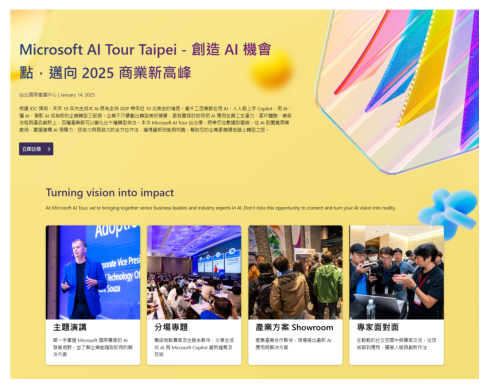

ID: 7
Score: 0.77892065
Content:  '本次 Microsoft AI Tour Taipei 活動將於台北國際會議中心舉辦'
Image file: 7.png

image_url:  https://paytonavatarimage.blob.core.windows.net/aitour-images/7.png


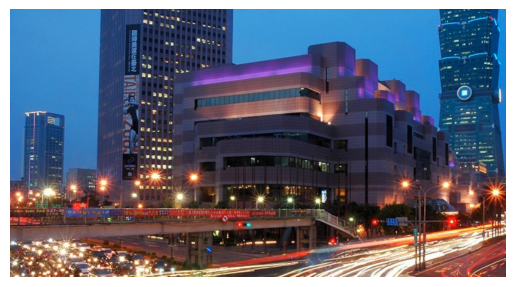

ID: 6
Score: 0.72960514
Content:  '精彩演講:以下是活動中的一些重點演講：- AI Transformation：Transform your business with Copilot + Agents  - Shaping the Future：AI Trends and Innovations  - Secure your identity in the era of AI  - 迎戰 2025 數位轉型新局：跨產業導入 Microsoft Copilot 實例分享  - Microsoft 365 Copilot：從實踐、應用到推廣的全方位指南  '
Image file: 6.png

image_url:  https://paytonavatarimage.blob.core.windows.net/aitour-images/6.png


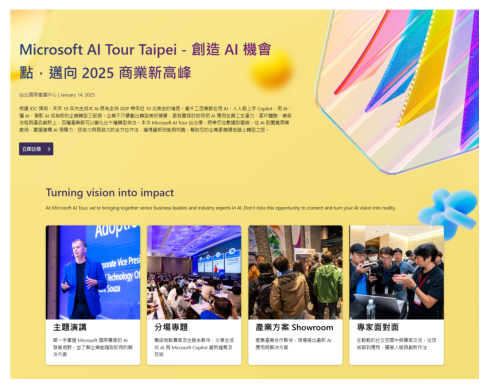

In [70]:
# Test code for using BlobServiceClient
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from PIL import Image

def display_image_from_blob(image_file):
    # Use public blob storage URL to display image
    image_url = (
        "https://paytonavatarimage.blob.core.windows.net/aitour-images/" + image_file
    )
    print("image_url: ", image_url)
    response = requests.get(image_url)
    blob_data = response.content

    img = plt.imread(BytesIO(blob_data))
    plt.imshow(img)
    plt.axis('off')  # No axes for this plot
    plt.show()

def print_results(results):
  print("Results:")
  print(results)
  for result in results:
    print(f"ID: {result['id']}")
    print(f"Score: {result['@search.score']}")
    print(f"Content: {result['content']}")  
    print(f"Image file: {result['product_image_file']}\n")
    display_image_from_blob(result['product_image_file'])

# Pure Vector Search
#query = "請問Microsoft AI Tour Taipei有哪些精彩演講?"
query = "請介紹Microsoft AI Tour Taipei"
#query = "請問活動會議在哪裡舉辦?"
#query = "請介紹展場的合作夥伴"
#query = "請問Copilot議題, 有哪些議程?"

results = search_client.search(  
    search_text=None,  
    vector=generate_embeddings(query), top_k=3,  
    vector_fields="content_vector",
    select= fields_of_interest
)  
print_results(results)